In [ ]:
import pickle

import bento
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import brier_score_loss, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer, LabelEncoder

In [4]:
data = bento.io.read_h5ad("../../data/locfish/locfish_eval_20211019.h5ad")
data.shape

(10000, 1)

In [5]:
cell_by_feature = bento.tl.get_features(
    data, bento.tl.PATTERN_MODEL_FEATURE_NAMES, min_count=0
)
cell_by_feature.head()

,,cell_inner_proximity,nucleus_inner_proximity,nucleus_outer_proximity,cell_inner_asymmetry,nucleus_inner_asymmetry,nucleus_outer_asymmetry,l_max,l_max_gradient,l_min_gradient,l_monotony,l_half_radius,point_dispersion,nucleus_dispersion
cell,gene,,,,,,,,,,,,,
mRNAlevel_100-cell2D-moderate-w1_HelaKyoto_Gapdh_2597_p20_cy3__Cell_CP_21__cell2D__25995-0,0,0.829736,0.851020,0.620248,0.818451,0.432661,0.943112,2.588469,0.595780,-0.628860,-0.997451,-22.290045,1.384136,1.328042
mRNAlevel_10-cell2D-weak-w1_HelaKyoto_Gapdh_2597_p21_cy3__Cell_CP_20__cell2D__28976-0,0,0.825032,0.787775,0.791329,0.734160,0.346235,0.786008,9.846196,2.569239,-1.000000,-0.959401,-13.461411,0.919131,0.927827
mRNAlevel_200-cell2D-moderate-w1_HelaKyoto_Gapdh_2597_p14_cy3__Cell_CP_28__cell2D__17988-0,0,0.827042,0.814255,0.598638,0.783305,0.312828,0.917744,2.198155,0.442243,-0.631441,-0.999329,-25.583847,1.348785,1.343532
mRNAlevel_100-cell2D-strong-w1_HelaKyoto_Gapdh_2597_p22_cy3__Cell_CP_26__cell2D__31657-0,0,0.891717,0.874524,0.589783,0.813132,0.376730,0.923885,2.112563,0.604250,-0.692180,-0.999425,-31.958605,1.295479,1.325677
mRNAlevel_400-cell2D-moderate-w1_HelaKyoto_Gapdh_2597_p14_cy3__Cell_CP_13__cell2D__16986-0,0,0.805541,0.835902,0.744821,0.789135,0.475451,0.903744,1.961746,0.393886,-0.579349,-0.998678,-14.650076,1.332575,1.337972


## Prepare datasets

In [6]:
classes = bento._utils.PATTERN_NAMES

Split train/test features

In [7]:
X = cell_by_feature.to_numpy()

le = LabelBinarizer().fit(classes)
y = le.transform(data.to_df("pattern").values.flatten())

X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.8, random_state=22, stratify=y
)

# Calibrate model

In [8]:
model = pickle.load(open(f"../../models/ml_multilabel_20211102/rf_model.pkl", "rb"))

In [26]:
prob_pos_clf = model.predict_proba(X_test)

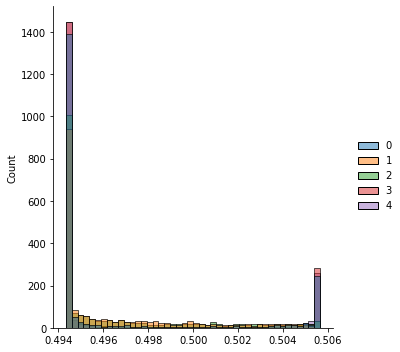

In [27]:
sns.displot(prob_pos_clf)

With isotonic calibration

In [23]:
clf_isotonic = CalibratedClassifierCV(model, cv="prefit", method="isotonic")
clf_isotonic.fit(X_test, y_test)
prob_pos_isotonic = clf_isotonic.predict_proba(X_test)

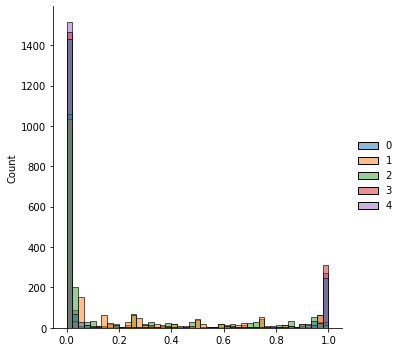

In [19]:
sns.displot(clf_isotonic.predict_proba(X_test))

In [30]:
print("Brier score losses: (the smaller the better)")

for i in range(5):
    clf_score = brier_score_loss(y_test[:, i], prob_pos_clf[:, i])
    print("No calibration: %1.3f" % clf_score)

for i in range(5):
    clf_isotonic_score = brier_score_loss(y_test[:, i], prob_pos_isotonic[:, i])
    print("With isotonic calibration: %1.3f" % clf_isotonic_score)

Brier score losses: (the smaller the better)
No calibration: 0.245
No calibration: 0.246
No calibration: 0.246
No calibration: 0.245
No calibration: 0.245
With isotonic calibration: 0.016
With isotonic calibration: 0.066
With isotonic calibration: 0.062
With isotonic calibration: 0.009
With isotonic calibration: 0.008


In [114]:
pickle.dump(clf_isotonic, open(f"../../models/rf_calib_20220514.pkl", "wb"))